<a href="https://colab.research.google.com/github/devitos-yale/cpsc334/blob/main/Copy_of_DeVito_Assignment6_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

import vgg as v
import utils
from utils import progress_bar

import sys
sys.argv=['']
del sys

parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')
args = parser.parse_args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [ ]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Model (VGG11)
print('==> Building model..')
#import vgg
net = v.VGG('VGG11')
# net = ResNet18()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF()
#net = SimpleDLA()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    loss = (train_loss/(batch_idx+1))
    acc = (100.*correct/total)
    return loss, acc

In [ ]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    
    loss = (test_loss/(batch_idx+1))
    return_acc = (100.*correct/total)
    return loss, return_acc


In [ ]:
trainingLoss = []
trainingAccuracy = []
testLoss = []
testAccuracy = []
for epoch in range(start_epoch, start_epoch+4):
    #start_epoch+200
    #print(epoch)
    loss, acc = train(epoch)
    trainingLoss.append(loss)
    trainingAccuracy.append(acc)

    loss, acc = test(epoch)
    testLoss.append(loss)
    testAccuracy.append(acc)

    scheduler.step()


Epoch: 0
 [================================================================>]  Step: 66ms | Tot: 38s611ms | Loss: 2.571 | Acc: 11.354% (5677/50000) 391/391 
 [================================================================>]  Step: 51ms | Tot: 5s59ms | Loss: 2.271 | Acc: 12.240% (1224/10000) 100/100 
Saving..

Epoch: 1
 [================================================================>]  Step: 86ms | Tot: 38s540ms | Loss: 2.056 | Acc: 18.996% (9498/50000) 391/391 
 [================================================================>]  Step: 127ms | Tot: 5s66ms | Loss: 2.036 | Acc: 21.400% (2140/10000) 100/100 
Saving..

Epoch: 2
 [================================================================>]  Step: 94ms | Tot: 38s810ms | Loss: 1.681 | Acc: 34.378% (17189/50000)

Text(0, 0.5, 'Training Accuracy')

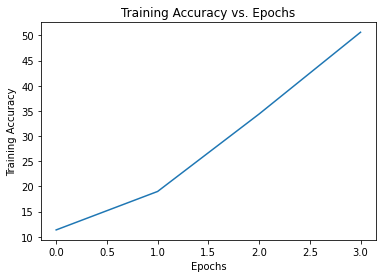

In [ ]:
plt.plot(range(start_epoch, start_epoch+4), trainingAccuracy)
plt.title('Training Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

Text(0, 0.5, 'Training Loss')

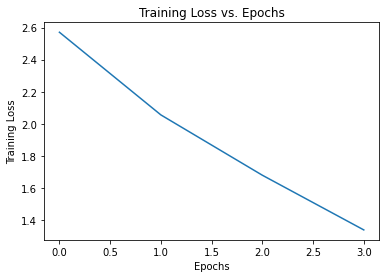

In [ ]:
plt.plot(range(start_epoch, start_epoch+4), trainingLoss)
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

Text(0, 0.5, 'Test Loss')

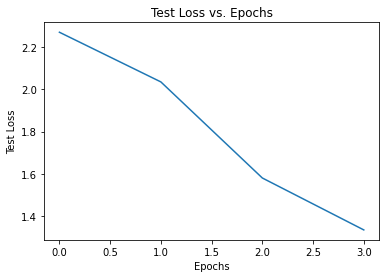

In [ ]:
plt.plot(range(start_epoch, start_epoch+4), testLoss)
plt.title('Test Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')

Text(0, 0.5, 'Test Accuracy')

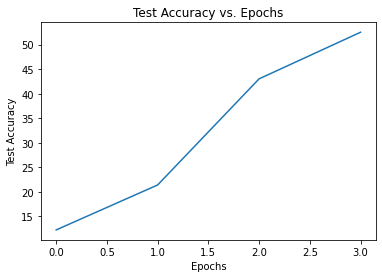

In [ ]:
plt.plot(range(start_epoch, start_epoch+4), testAccuracy)
plt.title('Test Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')

In [ ]:
torch.save(net.state_dict(), 'vgg11model.pth')

In [ ]:
state_dict = torch.load('vgg11model.pth')

import torchvision.models as models
import torch

import flops_counter as f
#from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  #net = models.densenet161()
  #og shape: (3, 224, 224)
  macs, params = f.get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  #print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  #print('{:<30}  {:<8}'.format('Number of parameters: ', params))
  print('Computational complexity: ', macs)
  print('Number of parameters: ', params)

Computational complexity:  7.82 GMac
Number of parameters:  28.68 M


Airplane


<Figure size 432x288 with 0 Axes>

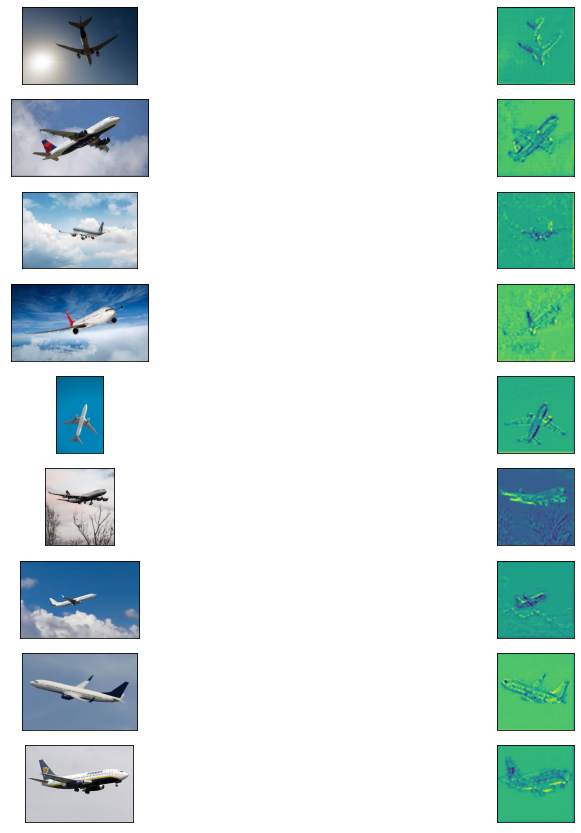

In [ ]:
from gradcam import *
from misc_functions import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure()

f, axarr = plt.subplots(9,2,figsize=(15,15))
print('Airplane')


# Get params
#target_example = 0  # Snake
#(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_example_params(target_example)
# Grad cam

for i in range(0, 9):
  pretrained_model = models.vgg11(pretrained=True)
  filepath = 'drive/MyDrive/Colab Notebooks/airplanes/' + str(i) + '.jpg'
  original_image = Image.open(filepath).convert('RGB')
  
  axarr[i][0].imshow(original_image)

  target_class = 0
  file_name_to_export = 'example'
  prep_img = preprocess_image(original_image)
  #prep_img = original_image.resize((224, 224), Image.ANTIALIAS)

  grad_cam = GradCam(pretrained_model, target_layer=5)
  cam = grad_cam.generate_cam(prep_img, target_class)
  axarr[i][1].imshow(cam)
  axarr[i][0].set_xticks([])
  axarr[i][0].set_yticks([])
  axarr[i][1].set_xticks([])
  axarr[i][1].set_yticks([])




could not transform PIL_img to a PIL Image object. Please check input.


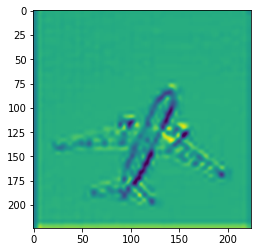

In [ ]:
original_image = Image.open('drive/MyDrive/Colab Notebooks/airplanes/download-2.jpg')
prep_img = preprocess_image(original_image)
grad_cam = GradCam(pretrained_model, target_layer=5)
cam2 = grad_cam.generate_cam(prep_img, target_class)
plt.imshow(cam2)